# WISDM HAR

Class
- Walking, Jogging, Upstairs, Downstairs, Sitting, Standing

Sampling rate
- 20Hz

Fields
- user, activity, timestamp, x-acceleration, y-acceleration, z-acceleration



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, MaxPool1D, BatchNormalization, Dense, Input, ReLU, Dropout, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/AI_data/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";") # comment: ';'로 시작하는 줄 무시(주석)


In [4]:
data.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis,NaN
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,NaN
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,NaN
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,NaN
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,NaN
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,NaN


In [5]:
df = data.drop('NaN', axis=1)
df.isna().sum()

,0
user_id,0
activity,0
timestamp,0
x_axis,0
y_axis,0
z_axis,1


In [6]:
df = df.dropna()
df.isna().sum()

,0
user_id,0
activity,0
timestamp,0
x_axis,0
y_axis,0
z_axis,0


In [7]:
df["z_axis"] = df["z_axis"].replace(regex=True, to_replace=r';', value=r'')

df["x_axis"] = df["x_axis"].astype('float32')
df["y_axis"] = df["y_axis"].astype('float32')
df["z_axis"] = df["z_axis"].astype('float32')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x_axis     1098203 non-null  float32
 4   y_axis     1098203 non-null  float32
 5   z_axis     1098203 non-null  float32
dtypes: float32(3), int64(2), object(1)
memory usage: 46.1+ MB


In [8]:
df['activity'].value_counts()

,count
activity,
Walking,424397
Jogging,342176
Upstairs,122869
Downstairs,100427
Sitting,59939
Standing,48395


In [9]:
df['user_id'].value_counts()

,count
user_id,
20,56632
19,45383
31,44282
8,41188
29,38245
14,38192
13,37093
34,35947
32,35506


In [10]:
# Label Encoding
label_encoder = LabelEncoder()
df['activity_encoded'] = label_encoder.fit_transform(df['activity'])
num_classes = len(label_encoder.classes_)

df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis,activity_encoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1


In [11]:
# label_encoder 매핑 결과 보기
dict(enumerate(label_encoder.classes_))

{0: 'Downstairs',
 1: 'Jogging',
 2: 'Sitting',
 3: 'Standing',
 4: 'Upstairs',
 5: 'Walking'}

In [12]:
# Data Split
df_train = df[df['user_id'] <= 28]
df_val = df[(df['user_id'] > 28) & (df['user_id'] <= 32)]
df_test = df[df['user_id'] > 32]

In [13]:
# 정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_train.loc[:, ['x_axis', 'y_axis', 'z_axis']] = scaler.fit_transform(df_train.loc[:, ['x_axis', 'y_axis', 'z_axis']])
# test 셋에서 train에서 학습한 scaler 사용
df_val.loc[:, ['x_axis', 'y_axis', 'z_axis']] = scaler.transform(df_val.loc[:, ['x_axis', 'y_axis', 'z_axis']])
df_test.loc[:, ['x_axis', 'y_axis', 'z_axis']] = scaler.transform(df_test.loc[:, ['x_axis', 'y_axis', 'z_axis']])

Segmentation
- 슬라이딩 윈도우 방식
- 데이터를 time_steps만큼 자르고 step 간격으로 이동
- 해당 구간에서 가장 많이 나타난 label을 출력값으로 저장
- 결과적으로 딥러닝 모델에 넣을 수 있는 3차원 입력 데이터와 라벨 벡터를 생성
- 3차원 입력 데이터: (샘플 수, 한 샘플이 가지는 시간 길이, feature 개수)

In [14]:
def create_dataset(x, y, time_steps=200, step=40):
    xs, ys = [], []
    for i in range(0, len(x) - time_steps, step):
        v = x.iloc[i:i + time_steps].values
        labels = y.iloc[i:i + time_steps]
        values, counts = np.unique(labels, return_counts=True)
        mode_label = values[np.argmax(counts)]
        xs.append(v)
        ys.append(mode_label)
    return np.array(xs), np.array(ys)

TIME_STEPS = 100
STEP = 50
x_train, y_train = create_dataset(df_train[['x_axis', 'y_axis', 'z_axis']], df_train['activity_encoded'], TIME_STEPS, STEP)
x_val, y_val = create_dataset(df_val[['x_axis', 'y_axis', 'z_axis']], df_val['activity_encoded'], TIME_STEPS, STEP)
x_test, y_test = create_dataset(df_test[['x_axis', 'y_axis', 'z_axis']], df_test['activity_encoded'], TIME_STEPS, STEP)

In [15]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((16694, 100, 3), (16694,), (2866, 100, 3), (2866,), (2400, 100, 3), (2400,))

In [16]:
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(weights))
print(class_weights_dict)

{0: np.float64(1.858606101091071), 1: np.float64(0.5291619120071003), 2: np.float64(3.324173636001593), 3: np.float64(4.177677677677678), 4: np.float64(1.4870835560306432), 5: np.float64(0.4238131505458238)}


## Model 1
- CNN 3, LSTM 1

In [17]:
input_shape = (x_train.shape[1], x_train.shape[2])
num_classes = 6

model = Sequential([
    Input(shape=input_shape),

    Conv1D(64, 5, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv1D(128, 3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPool1D(),

    Conv1D(256, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    LSTM(256, return_sequences=False),

    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 100, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 50, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 718,726 (2.74 MB)

 Trainable params: 717,830 (2.74 MB)

 Non-trainable params: 896 (3.50 KB)

None


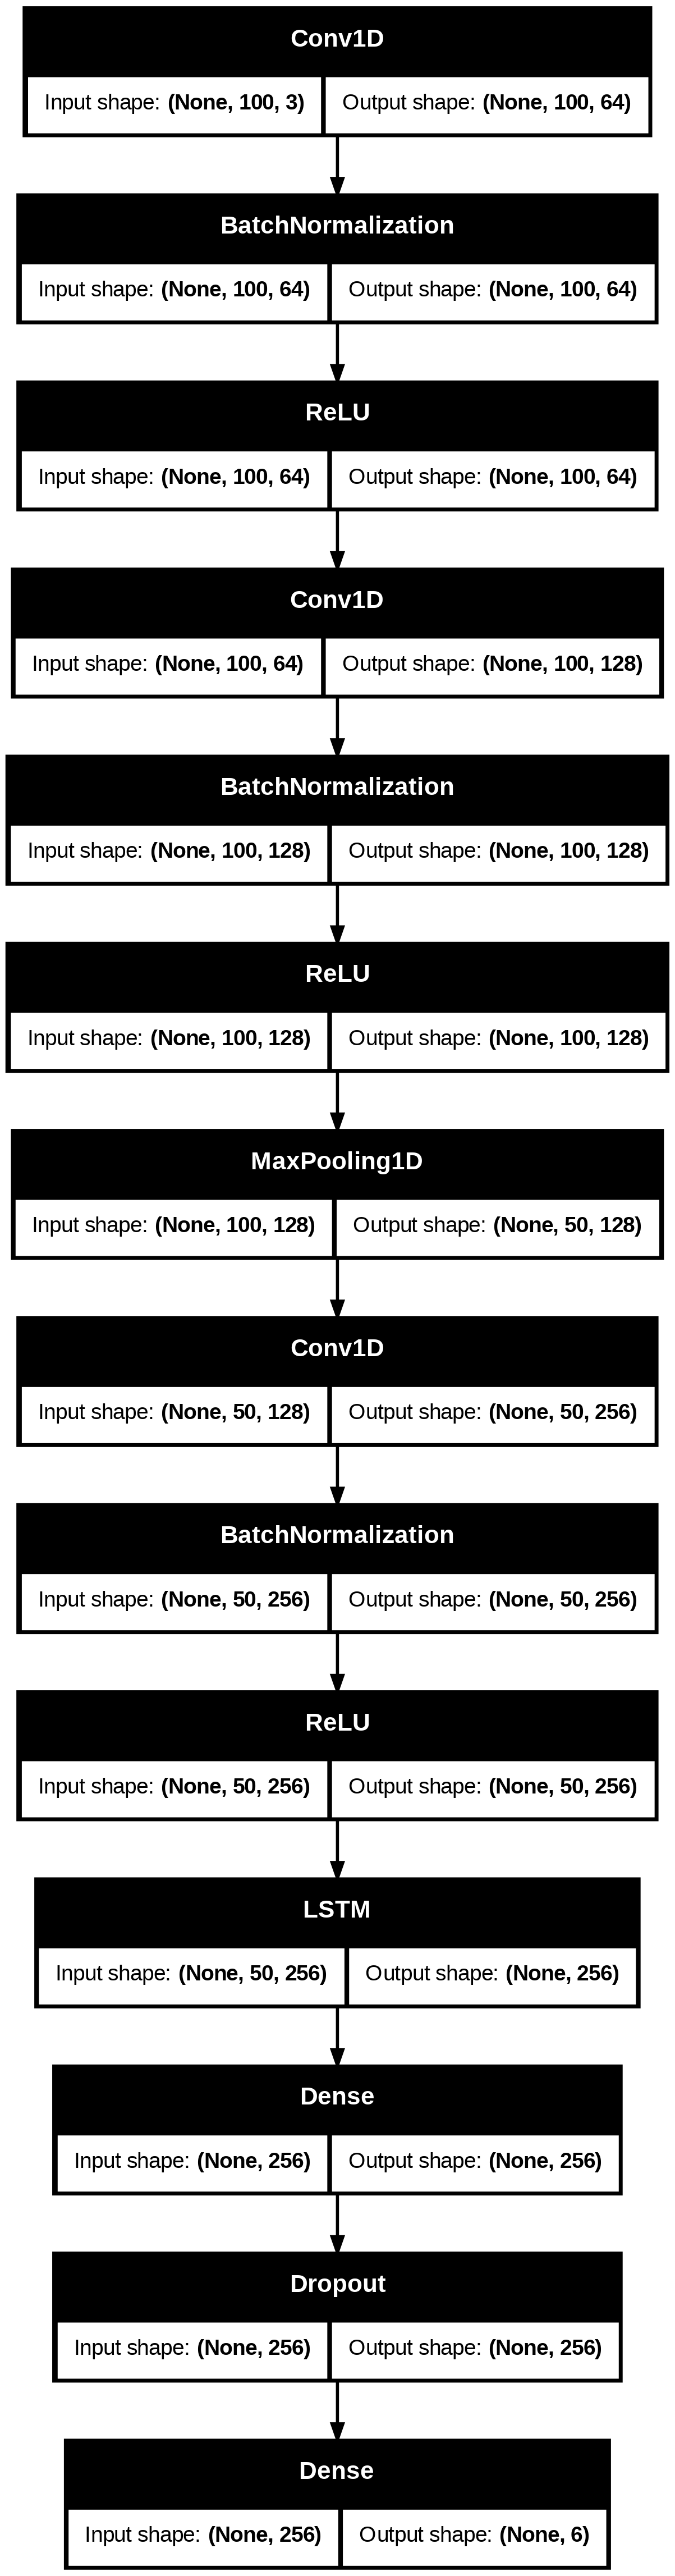

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [21]:
callbacks = [
            ModelCheckpoint(
                "WIDSM_HAR_CNN_LSTM_best.h5",
                save_best_only=True,
                monitor="val_loss",
                mode='min',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_loss",
                patience=20,
                verbose=1,
                mode='min',
                restore_best_weights=True
            )
        ]

In [22]:
history = model.fit(
            x_train, y_train,
            epochs=50,
            batch_size=64,
            validation_data=(x_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/50
260/261 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1957 - sparse_categorical_accuracy: 0.9327
Epoch 1: val_loss improved from inf to 0.61735, saving model to WIDSM_HAR_CNN_LSTM_best.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.1956 - sparse_categorical_accuracy: 0.9327 - val_loss: 0.6173 - val_sparse_categorical_accuracy: 0.7861
Epoch 2/50
258/261 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1271 - sparse_categorical_accuracy: 0.9567
Epoch 2: val_loss did not improve from 0.61735
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.1270 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.6852 - val_sparse_categorical_accuracy: 0.8112
Epoch 3/50
259/261 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0853 - sparse_categorical_accuracy: 0.9725
Epoch 3: val_loss did not improve from 0.61735
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0852 - sparse_categorical_accuracy: 0.9725 - val_loss: 1.0098 - val_sparse_categorical_accuracy: 0.8391
Epoch 4/50
260/261 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0818 - sparse_categorical_accuracy: 0.9740
Epoch 4: val_loss did not improve from 0.61735
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0818 - sparse_categor

In [23]:
# 모델 평가
model = tf.keras.models.load_model("WIDSM_HAR_CNN_LSTM_best.h5")

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 95.39%
Training loss: 0.1243
Test accuracy: 82.13%
Test loss: 0.5465


In [24]:
y_pred_proba = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.7667    0.8070    0.7863       228
           1     1.0000    0.6733    0.8047       808
           2     0.8585    0.9888    0.9191       178
           3     0.8165    0.7417    0.7773       120
           4     0.3736    0.7137    0.4905       234
           5     0.9485    0.9748    0.9615       832

    accuracy                         0.8213      2400
   macro avg     0.7940    0.8165    0.7899      2400
weighted avg     0.8793    0.8213    0.8338      2400



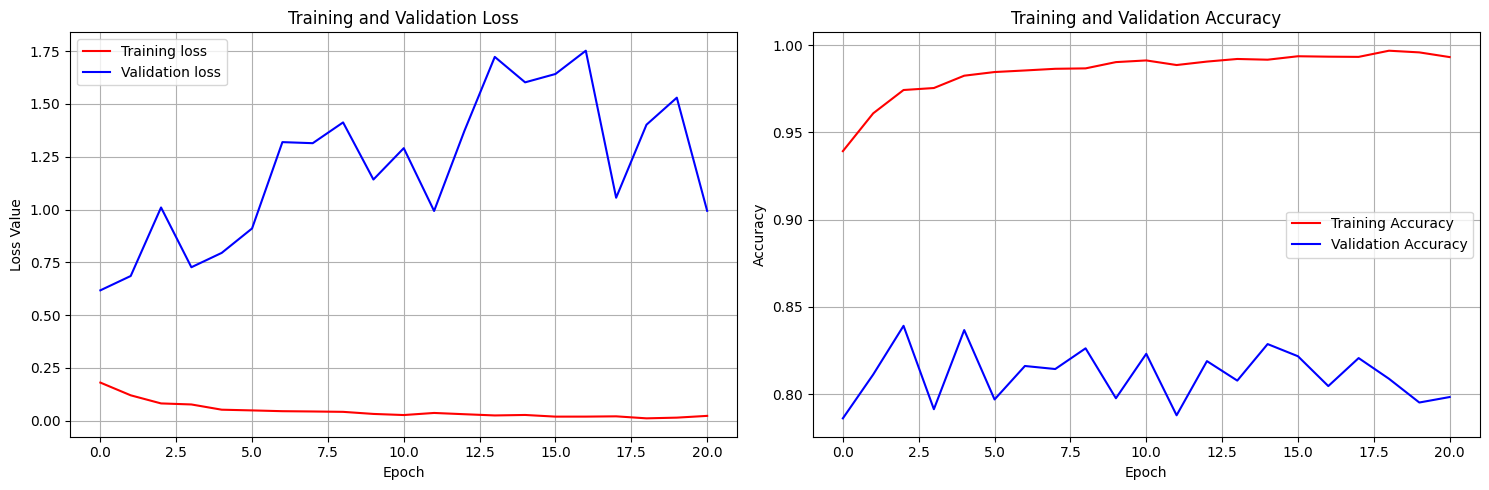

In [25]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

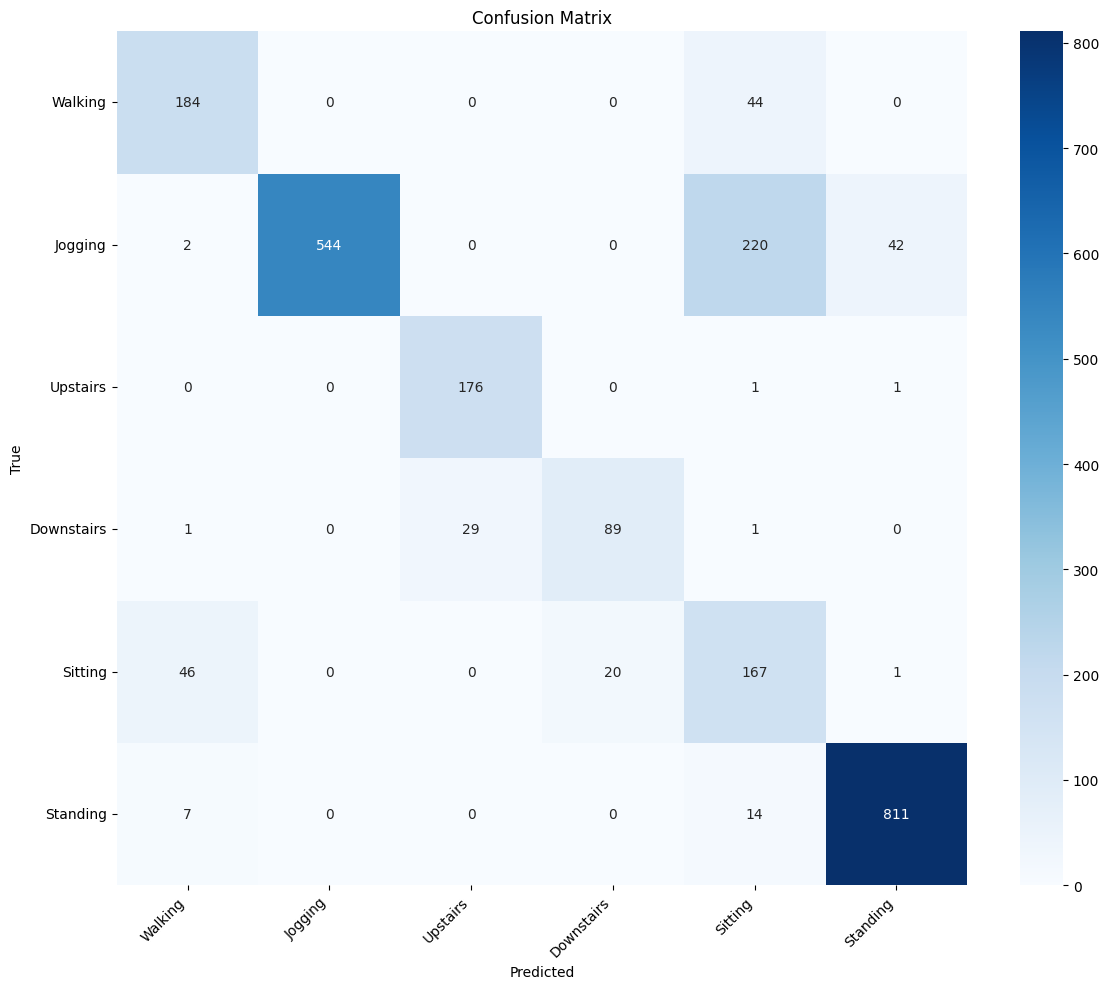

In [26]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

classes = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
plt.gca().set_xticklabels(classes, rotation=45, ha='right')
plt.gca().set_yticklabels(classes, rotation=0)

plt.tight_layout()
plt.show()

## Model 2
- CNN 2, LSTM 1

In [27]:
input_shape = (x_train.shape[1], x_train.shape[2])
num_classes = 6

model = Sequential([
    Input(shape=input_shape),

    Conv1D(64, 5, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPool1D(),

    Conv1D(128, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    LSTM(128, return_sequences=False),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 100, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 50, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,366 (685.02 KB)

 Trainable params: 174,982 (683.52 KB)

 Non-trainable params: 384 (1.50 KB)

None


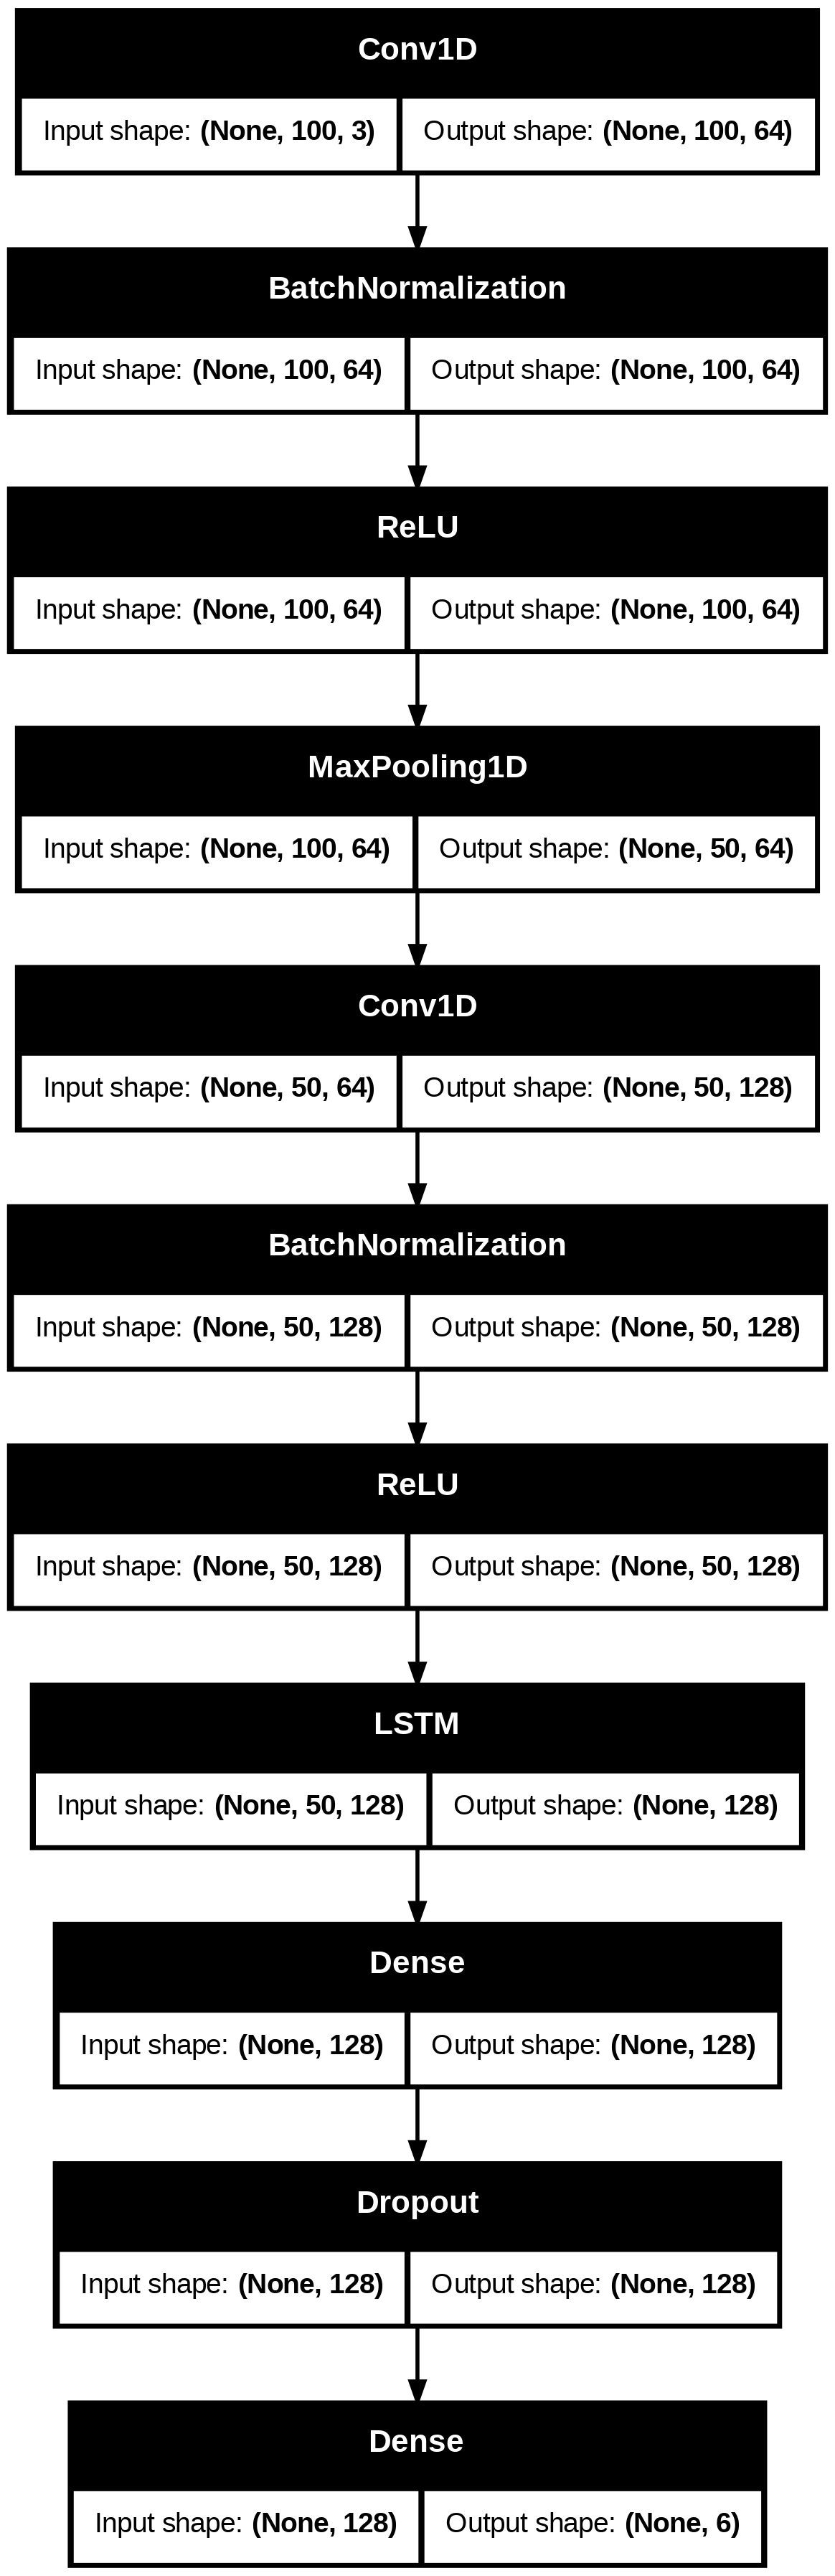

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [29]:
callbacks = [
            ModelCheckpoint(
                "WIDSM_HAR_CNN_LSTM_best2.h5",
                save_best_only=True,
                monitor="val_loss",
                mode='min',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_loss",
                patience=20,
                verbose=1,
                mode='min',
                restore_best_weights=True
            )
        ]

In [30]:
history = model.fit(
            x_train, y_train,
            epochs=50,
            batch_size=64,
            validation_data=(x_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/50
260/261 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7164 - sparse_categorical_accuracy: 0.7526
Epoch 1: val_loss improved from inf to 1.05865, saving model to WIDSM_HAR_CNN_LSTM_best2.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.7149 - sparse_categorical_accuracy: 0.7532 - val_loss: 1.0587 - val_sparse_categorical_accuracy: 0.7683
Epoch 2/50
259/261 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3112 - sparse_categorical_accuracy: 0.8865
Epoch 2: val_loss improved from 1.05865 to 0.77372, saving model to WIDSM_HAR_CNN_LSTM_best2.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3106 - sparse_categorical_accuracy: 0.8867 - val_loss: 0.7737 - val_sparse_categorical_accuracy: 0.7613
Epoch 3/50
258/261 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1681 - sparse_categorical_accuracy: 0.9412
Epoch 3: val_loss did not improve from 0.77372
261/261 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1679 - sparse_categorical_accuracy: 0.9413 - val_loss: 0.8316 - val_sparse_categorical_accuracy: 0.7683
Epoch 4/50
256/261 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1347 - sparse_categorical_accuracy: 0.9558
Epoch 4: val_loss did not improve from 0.77372
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1344 - sparse_categorical_accuracy: 0.9558 - val_loss: 1.0653 - val_sparse_categorical_accuracy: 0.7896
Epoch 5/50
260/261 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1047 - sparse_categorical_accuracy: 0.9665
Epoch 5: val_loss did not improve from 0.77372
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1047 - sparse_categor

In [31]:
# 모델 평가
model = tf.keras.models.load_model("WIDSM_HAR_CNN_LSTM_best2.h5")

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 93.47%
Training loss: 0.1625
Test accuracy: 82.04%
Test loss: 0.5399


In [32]:
y_pred_proba = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.5876    0.4561    0.5136       228
           1     1.0000    0.7946    0.8855       808
           2     0.9832    0.9888    0.9860       178
           3     0.6763    0.9750    0.7986       120
           4     0.3506    0.6068    0.4444       234
           5     0.9563    0.9471    0.9517       832

    accuracy                         0.8204      2400
   macro avg     0.7590    0.7947    0.7633      2400
weighted avg     0.8649    0.8204    0.8332      2400



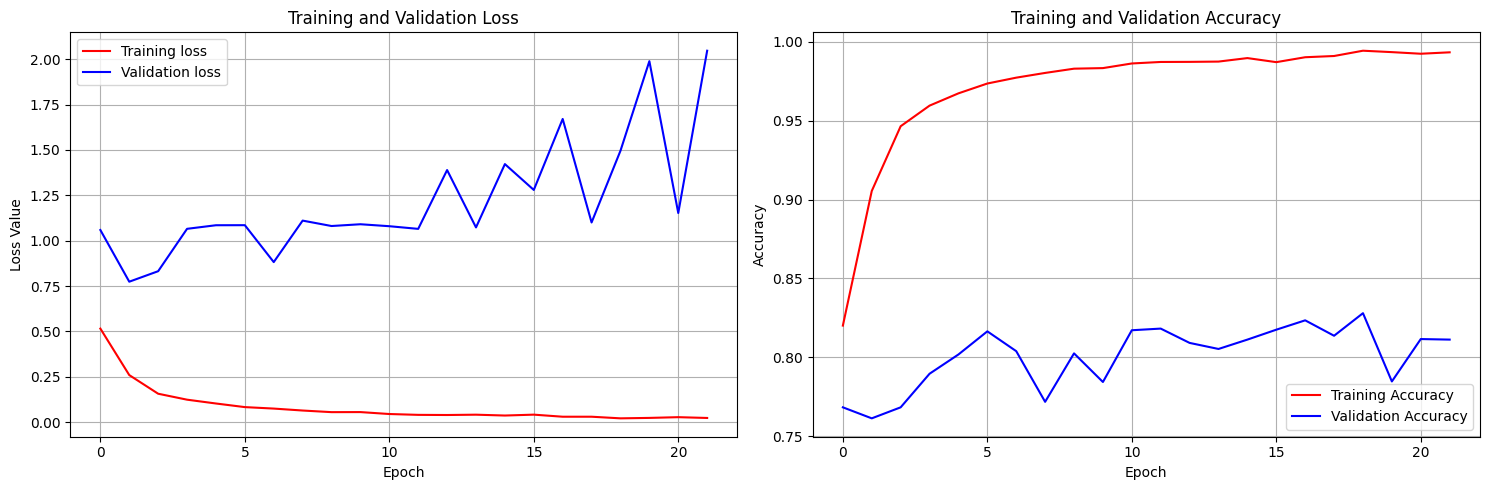

In [33]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

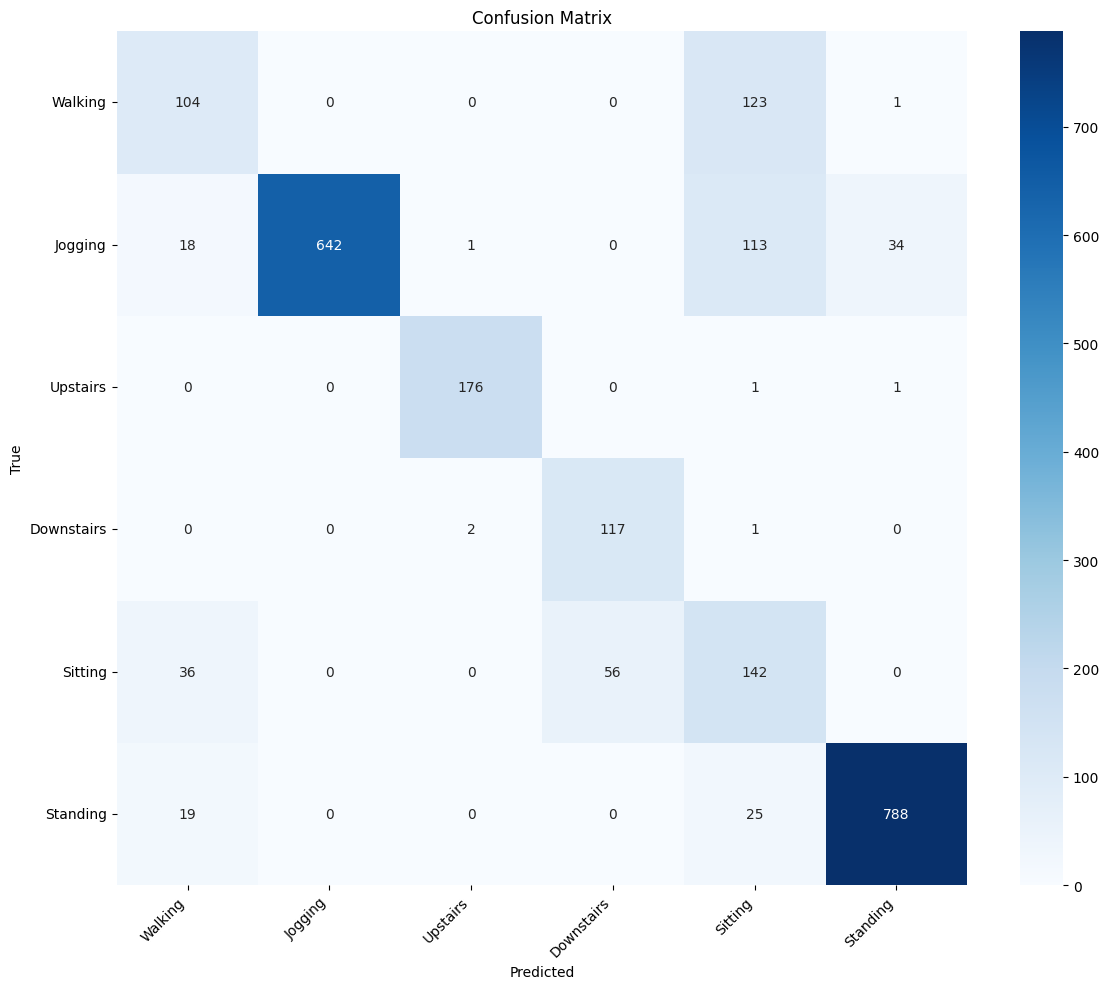

In [34]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

classes = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
plt.gca().set_xticklabels(classes, rotation=45, ha='right')
plt.gca().set_yticklabels(classes, rotation=0)

plt.tight_layout()
plt.show()